# SITC - Proyecto Final: Twitter football analysis

- Crespo Bolaños, Priscila
- Juliana Quiros, Gregorio
- Murillo Ramos, David
- Pascual Landa, Ignacio
- Rodriguez Villalba, Álvaro

## Sentiment classification for Twitter

### Obtención de datos etiquetados

In [1]:
#Leemos el fichero de los datos sin etiquetar
# General import and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# if matplotlib is not set inline, you will not see plots
#alternatives auto gtk gtk2 inline osx qt qt5 wx tk
#%matplotlib auto
#%matplotlib qt
%matplotlib inline
%run plot_learning_curve

tweets = pd.read_csv('football-twitter/train.csv')
tweets.head()

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


,id,text,polarity
0,9f5c7536,Recorriendo el #CampNou🏟 https://t.co/ZKZ1ERaiZS,Neutral
1,8e59cbaa,@FCBarcelona fera desde pequeno😲😲,Neutral
2,a2c38968,@sport Y el barca que haria sin Messi????? Ni ...,Negative
3,51cf6477,Please RT!! #barcelona #fcbarcelona #Barca #fc...,Neutral
4,2a1bb2a5,"@NostradamusFCB Si parce que miedo, sólo el ba...",Neutral


In [2]:
tweets.dtypes

id          object
text        object
polarity    object
dtype: object

In [3]:
tweets.polarity.unique()

array(['Neutral', 'Negative', 'Positive'], dtype=object)

In [4]:
tweets.groupby('polarity').size()

polarity
Negative    142
Neutral     208
Positive     61
dtype: int64

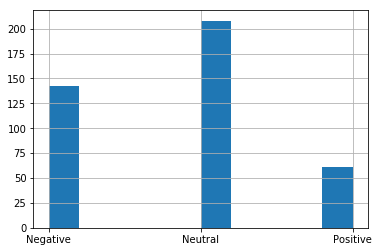

In [5]:
tweets['polarity'].hist()

In order to have mora data for train the model and improve the predictions we'll use the labeled TASS Spanish Corpus. For being able to use it we need to fill a form to request the download of it (http://www.sepln.org/workshops/tass/tass_data/download.php).

The sentiemnt of the tweets of the corpus are annotated in a scale of 4 levels of polarity: P, NEU, N and NONE. The corpus has three datasets:

- Training: it is composed of 1008 tweets.
- Development: it is composed of 506 tweets.
- Test: it is composed of 1899 tweets.

In [6]:
#socialtv-tweets
tweets_socialtv_train = pd.read_csv('TASS Spanish Corpus/socialtv-tweets-train.csv')

tweets_socialtv_train.columns = ['text', 'polarity']

tweets_socialtv_train.polarity[tweets_socialtv_train.polarity=='P'] = 'Positive'
tweets_socialtv_train.polarity[tweets_socialtv_train.polarity=='NEU'] = 'Neutral'
tweets_socialtv_train.polarity[tweets_socialtv_train.polarity=='N'] = 'Negative'

tweets_socialtv_train.head()

,text,polarity
0,Alves échate unos bailes loco,Positive


In [7]:
#stompol tweets
tweets_stompol_train = pd.read_csv('TASS Spanish Corpus/stompol-train-tagged.csv')

tweets_stompol_train.columns = ['text', 'polarity']

tweets_stompol_train.polarity[tweets_stompol_train.polarity=='P'] = 'Positive'
tweets_stompol_train.polarity[tweets_stompol_train.polarity=='NEU'] = 'Neutral'
tweets_stompol_train.polarity[tweets_stompol_train.polarity=='N'] = 'Negative'

tweets_stompol_train.head()

,text,polarity
0,Un 25% de los españoles cree que es el Sol el ...,Negative


In [8]:
#general tweets
general_tweets_train = pd.read_csv('TASS Spanish Corpus/general-tweets-train.csv')

general_tweets_train.drop(['agreement'], axis=1, inplace=True)

general_tweets_train.columns = ['text', 'polarity']

general_tweets_train.polarity[general_tweets_train.polarity=='P'] = 'Positive'
general_tweets_train.polarity[general_tweets_train.polarity=='NEU'] = 'Neutral'
general_tweets_train.polarity[general_tweets_train.polarity=='N'] = 'Negative'

general_tweets_train.head()

,text,polarity
0,-Me caes muy bien \n-Tienes que jugar más part...,NONE
1,@myendlesshazza a. que puto mal escribo\n\nb. ...,Negative
2,@estherct209 jajajaja la tuya y la d mucha gen...,Negative
3,Quiero mogollón a @AlbaBenito99 pero sobretodo...,Positive
4,Vale he visto la tia bebiendose su regla y me ...,Negative


In [9]:
#concatenamos todos los resultados:
tweets = pd.concat([
        tweets,
        general_tweets_train,
        tweets_socialtv_train,
        tweets_stompol_train
    ])
tweets.sample(20)
tweets=tweets[tweets.polarity.isin(['Positive','Negative','Neutral'])]

In [11]:
tweets.groupby('polarity').size()

polarity
Negative    561
Neutral     341
Positive    380
dtype: int64

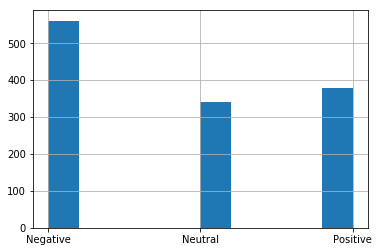

In [12]:
tweets['polarity'].hist()

As we see there are more tweets labeled as Negative than Positive. WE will try to equalize those values.

In [13]:
tweets_negative = tweets[tweets.polarity=='Negative']
tweets_negative.head()
tweets_toDelete = tweets_negative[:-360]
tweets_toDelete.count()

id          142
polarity    201
text        201
dtype: int64

In [14]:
tweets = tweets[~tweets.index.isin(tweets_toDelete.index)]
tweets.head()

,id,polarity,text
0,9f5c7536,Neutral,Recorriendo el #CampNou🏟 https://t.co/ZKZ1ERaiZS
3,51cf6477,Neutral,Please RT!! #barcelona #fcbarcelona #Barca #fc...
5,7c2deb3b,Neutral,@Matt_Santangelo Mino= No Barca.
12,81378a55,Neutral,"Con todo respeto, no le veo mucho sentido a es..."
13,7882c517,Neutral,@ALEX15vs @FCBarcelona_es @FCBarcelona El va p...


In [15]:
tweets.groupby('polarity').size()

polarity
Negative    323
Neutral     300
Positive    323
dtype: int64

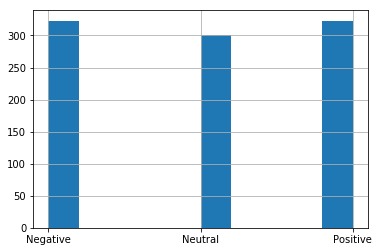

In [16]:
tweets['polarity'].hist()

Now we have a more distributed number of negative, positive and neutral tweets

In [17]:
tweets.shape

(946, 3)

### Tokenizing & Stemming

Once we have our corpus ready, we'll clean the tweets, removing stops words, tokenization, etc

In [18]:
#Palabras parada
import nltk
nltk.download("stopwords")
nltk.download('punkt')

from nltk.corpus import stopwords
spanish_stopwords = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/priscilacb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/priscilacb/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
print(spanish_stopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosostros', 'vosostras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 

In [20]:
#Signos de puntuación
from string import punctuation
non_words = list(punctuation)

#we add spanish punctuation
non_words.extend(['¿', '¡', '\u200d', '—', '“', '”', '…', '\U0001f929', '‘', '’'])
non_words.extend(map(str,range(10)))

In [21]:
non_words

['!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 ':',
 ';',
 '<',
 '=',
 '>',
 '?',
 '@',
 '[',
 '\\',
 ']',
 '^',
 '_',
 '`',
 '{',
 '|',
 '}',
 '~',
 '¿',
 '¡',
 '\u200d',
 '—',
 '“',
 '”',
 '…',
 '\U0001f929',
 '‘',
 '’',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

In [22]:
from sklearn.feature_extraction.text import CountVectorizer       
from nltk.stem import PorterStemmer, LancasterStemmer, WordNetLemmatizer
from nltk.tokenize import TweetTokenizer
tweet_tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)

# based on http://www.cs.duke.edu/courses/spring14/compsci290/assignments/lab02.html
stemmer = LancasterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize(text):
    # remove non letters
    text = ''.join([c for c in text if c not in non_words])
    # tokenize
    tokens =  tweet_tokenizer.tokenize(text)

    # stem
    try:
        stems = stem_tokens(tokens, stemmer)
    except Exception as e:
        print(e)
        print(text)
        stems = ['']
    return stems

## Evaluación del modelo

In [23]:
from sklearn.cross_validation import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

First, we will categorize the sentiment.
- Negative sentiments:0
- Positive sentiments:1
- Neutral sentiments:2

In [24]:
tweets['polarity_bin'] = 0
tweets.polarity_bin[tweets.polarity=='Positive'] = 1
tweets.polarity_bin[tweets.polarity=='Negative'] = 0
tweets.polarity_bin[tweets.polarity=='Neutral'] = 2

tweets.polarity_bin.value_counts(normalize=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


1    0.341438
0    0.341438
2    0.317125
Name: polarity_bin, dtype: float64

Now we create the models with the optimized parameters

In [25]:
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,
            stop_words = spanish_stopwords,
            max_features=5000
            )

#Aprender el vocabulario - SVC
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

pipeline = Pipeline([
    ('vect', vectorizer),
    ('cls', LinearSVC()),
])

param_grid = {    
    'vect__max_features': [1000, 2500, 5000],
    'vect__ngram_range': [[1, 1], [2, 2]],  # unigrams or bigrams
    'cls__C': (0.2, 0.5, 0.7),
    'cls__loss': ('hinge', 'squared_hinge'),
    'cls__max_iter': (500, 1000)
} 

gs_svc = GridSearchCV(pipeline, param_grid)
gs_svc.fit(tweets.text, tweets.polarity_bin)

#Evaluacion del modelo
# summarize the results of the grid search
print("Best score: ", gs_svc.best_score_)
print("Best params: ", gs_svc.best_params_)

Best score:  0.542283298097
Best params:  {'cls__C': 0.2, 'cls__loss': 'squared_hinge', 'cls__max_iter': 500, 'vect__max_features': 5000, 'vect__ngram_range': [1, 1]}


In [26]:
from sklearn.cross_validation import cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB


pipeline_NB = Pipeline([
    ('vect', vectorizer),
    ('cls', MultinomialNB()),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

param_grid = {    
    'vect__max_features': [1000, 2500, 5000],
    'vect__ngram_range': [[1, 1], [2, 2]],  # unigrams or bigrams
    'cls__alpha': [0.5, 1.0]
} 

gs_nb = GridSearchCV(pipeline_NB, param_grid)
gs_nb.fit(tweets.text, tweets.polarity_bin)

# summarize the results of the grid search
print("Best score: ", gs_nb.best_score_)
print("Best params: ", gs_nb.best_params_)

Best score:  0.550739957717
Best params:  {'cls__alpha': 1.0, 'vect__max_features': 5000, 'vect__ngram_range': [1, 1]}


In [28]:
#Regresion lineal
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

pipeline_LogR = Pipeline([
    ('vect', vectorizer),
    ('lr', LogisticRegression(n_jobs=-1)),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

param_grid = {    
    'vect__max_features': [1000, 2500, 5000],
    'vect__ngram_range': [[1, 1], [2, 2]],  # unigrams or bigrams
    'lr__C': (0.2, 0.5, 0.7),
    'lr__penalty': ['l1','l2']
}

gs_LogR = GridSearchCV(pipeline_LogR, param_grid)
gs_LogR.fit(tweets.text, tweets.polarity_bin)

# summarize the results of the grid search
print("Best score: ", gs_LogR.best_score_)
print("Best params: ", gs_LogR.best_params_)

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect whe

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect whe

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect whe

Best score:  0.549682875264
Best params:  {'lr__C': 0.2, 'lr__penalty': 'l2', 'vect__max_features': 1000, 'vect__ngram_range': [1, 1]}


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


In [27]:
#Knn
from sklearn.neighbors import KNeighborsClassifier
pipeline_knn = Pipeline([
    ('vect', vectorizer),
    ('knn', KNeighborsClassifier()),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

param_grid = {    
    'vect__max_features': [1000, 2500, 5000],
    'vect__ngram_range': [[1, 1], [2, 2]],  # unigrams or bigrams
    'knn__n_neighbors': list(range(1, 11))
}

gs_knn = GridSearchCV(pipeline_knn, param_grid)
gs_knn.fit(tweets.text, tweets.polarity_bin)

# summarize the results of the grid search
print("Best score: ", gs_knn.best_score_)
print("Best params: ", gs_knn.best_params_)

Best score:  0.50422832981
Best params:  {'knn__n_neighbors': 10, 'vect__max_features': 2500, 'vect__ngram_range': [1, 1]}


In [29]:
#MPL
from sklearn.neural_network import MLPClassifier

pipeline_mpl = Pipeline([
    ('vect', CountVectorizer(
            analyzer = 'word',
            tokenizer = tokenize,
            lowercase = True,
            stop_words = spanish_stopwords,
            )),
    ('mpl', MLPClassifier(max_iter=500)),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()

param_grid = {    
    'vect__max_features': [1000, 3000, 4000],
    'vect__ngram_range': [[1, 1], [2, 2]],  # unigrams or bigrams
    'mpl__hidden_layer_sizes': [(100,), (200,)]
} 

gs_mpl = GridSearchCV(pipeline_mpl, param_grid)
gs_mpl.fit(tweets.text, tweets.polarity_bin)

# summarize the results of the grid search
print("Best score: ", gs_mpl.best_score_)
print("Best params: ", gs_mpl.best_params_)

Best score:  0.529598308668
Best params:  {'mpl__hidden_layer_sizes': (100,), 'vect__max_features': 4000, 'vect__ngram_range': [1, 1]}


In [30]:
from sklearn import tree

#Decision Tree
pipeline_dt = Pipeline([
    ('vect', vectorizer),
    ('dt', tree.DecisionTreeClassifier()),
])
#Aprender el vocabulario
tweets_features = vectorizer.fit_transform(tweets.text)
tweets_features_nd = tweets_features.toarray()


param_grid = [{
        'vect__max_features': [1000, 3000, 4000],
        'vect__ngram_range': [[1, 1], [2, 2]],  # unigrams or bigrams
        'dt__max_depth': np.arange(3, 10),
        'dt__min_samples_leaf': [2, 5],
        'dt__max_leaf_nodes': [5, 10],
        'dt__criterion':['gini','entropy']}]

gs_dt = GridSearchCV(pipeline_dt, param_grid)
gs_dt.fit(tweets.text, tweets.polarity_bin)

# summarize the results of the grid search
print("Best score: ", gs_dt.best_score_)
print("Best params: ", gs_dt.best_params_)

Best score:  0.53911205074
Best params:  {'dt__criterion': 'gini', 'dt__max_depth': 5, 'dt__max_leaf_nodes': 10, 'dt__min_samples_leaf': 5, 'vect__max_features': 1000, 'vect__ngram_range': [1, 1]}


In [31]:
#Cargamos el fichero de tweets sin etiquetar
tweets_nolabel = pd.read_csv('football-twitter/test_nolabel.csv')
tweets_nolabel.head()

,id,text
0,aa24173d,Han robado por el método del alunizaje en la t...
1,79cdded5,@BenditalocuraAt @Atleti @fhervas13 FELICIDADE...
2,26fe7471,Dedicado para:\n@Trigueros17 \n@FCBarcelona ht...
3,d7d87d07,@Eribert42354852 El Barca aparte de ganar eso ...
4,c4852036,Vengo 2/2 con los clasificados a Cuartos de Ch...


In [32]:
tweets_nolabel.shape

(177, 2)

In [33]:
tweets_nolabel.dtypes

id      object
text    object
dtype: object

In [34]:
#Entrenamos el modelo con los datos del corpus
#pipeline.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=gs_svc.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')

In [35]:
dataframeResult.to_csv('out/out_svc_tdidt.csv', sep=',',index=False)

In [36]:
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=gs_nb.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out/out_nb_tdidt.csv', sep=',',index=False)

In [37]:
#Entrenamos el modelo con los datos del corpus
#pipeline_LogR.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=gs_LogR.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out/out_LogR_tdidt.csv', sep=',',index=False)

In [38]:
#Entrenamos el modelo con los datos del corpus
#pipeline_knn.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=gs_knn.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out/out_knn_tdidt.csv', sep=',',index=False)

In [39]:
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=gs_mpl.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out/out_mpl_tdidt.csv', sep=',',index=False)

In [40]:
#Entrenamos el modelo con los datos del corpus
#pipeline_dt.fit(tweets.text, tweets.polarity_bin)
#Realizamos las predicciones con los datos descargados directamente de Twitter
#tweets['polarity'] = pipeline.predict(tweets_nolabel.text)
#tweets[['tweet', 'polarity']].sample(20)

polarity=gs_dt.predict(tweets_nolabel.text)
dataframeResult = pd.read_csv('football-twitter/test_nolabel.csv').filter(['id'], axis=1)
dataframeResult['Polarity'] = polarity
dataframeResult[:]
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([0], 'Negative')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([1], 'Positive')
dataframeResult['Polarity'] = dataframeResult['Polarity'].replace([2], 'Neutral')
dataframeResult.to_csv('out/out_dt_tdidt.csv', sep=',',index=False)